<h2 align=center> Toxic Comments Classification using 1D CNN with Keras</h2>

### Import Packages and Functions

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D
from sklearn.model_selection import train_test_split
print(tf.__version__)

2.7.0


### Load and Explore Data

In [11]:
# Load data

train_df = pd.read_csv('toxic_train.csv').fillna(' ')

train_df.head(3)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0


In [12]:
# View few toxic comments
x = train_df['comment_text'].values
print(x)


["Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"
 "D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)"
 "Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info."
 ...
 'Spitzer \n\nUmm, theres no actual article for prostitution ring.  - Crunch Captain.'
 'And it looks like it was actually you who put on the speedy to have the first version deleted now that I look at it.'
 '"\nAnd ... I really don\'t think you understand.  I came here and my idea was bad right away.  What kind of community goes ""you have bad ideas"" go away, instead o

In [16]:
# View few toxic comments
train_df.loc[train_df['toxic']==1][['comment_text','toxic']].sample(10, random_state=10)

,comment_text,toxic
30575,"""\n Are you asking if we would ever block some...",1
36038,Amen my sock-pupinski brother!! Hack-a-long: p...,1
19730,JUST READ THE FUCKING CENSUS DATA. Do you thin...,1
72261,u no wat ass hole go fuck your self and stop b...,1
77923,Go fuck yourself \n\nEat shit and die. 68.0.11...,1
16382,A big thank you\n\nYou have just blocked me in...,1
41247,A message from Jasonceyre \n\n f uc k you ho...,1
69311,"I'm gonna get the ACLU on you, you racist anti...",1
142032,"Hey Freepsbane, does your mother know that you...",1
5613,You guys suk. You really really suck. Fuck you...,1


In [17]:
train_df1 = train_df[['comment_text','toxic']].copy()
train_df1.head()

,comment_text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [19]:
#! pip install wordcloud

     |████████████████████████████████| 220 kB 2.0 MB/s eta 0:00:01
  Created wheel for wordcloud: filename=wordcloud-1.8.1-cp39-cp39-macosx_10_9_x86_64.whl size=154224 sha256=2570708c89f07de7f0ff7f5a66542e089e986bcf45bf055f4882827ac468265f
  Stored in directory: /Users/admin/Library/Caches/pip/wheels/f9/7a/dd/06ef8b5dfe5483f6204133c08eeb16c287cc2c05e290ae2fc0
Successfully built wordcloud


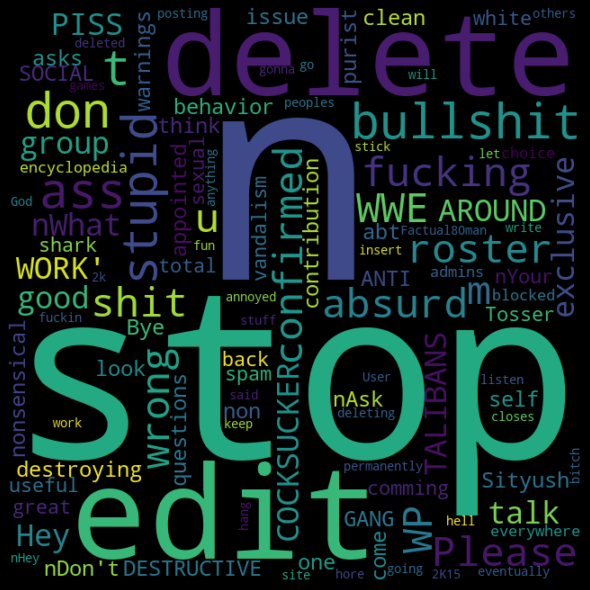

In [20]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
comments = train_df1['comment_text'].loc[train_df1['toxic']==1].values
wordcloud = WordCloud(
    width = 640,
    height = 640,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(comments))
fig = plt.figure(
    figsize = (12, 8),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

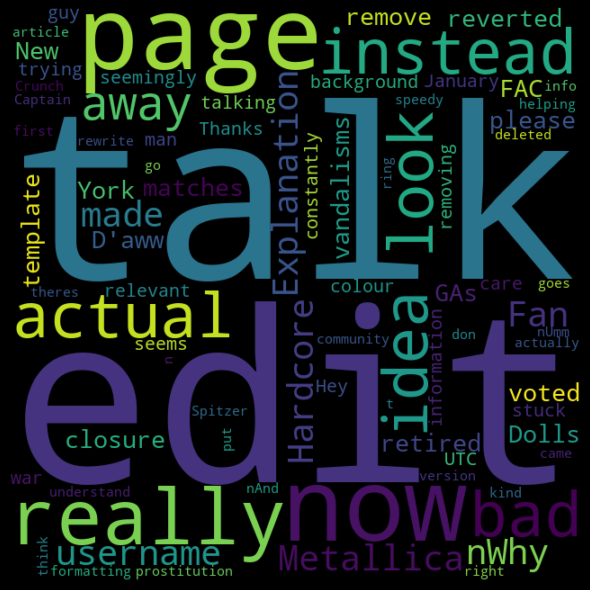

In [21]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
comments = train_df1['comment_text'].loc[train_df1['toxic']==0].values
wordcloud = WordCloud(
    width = 640,
    height = 640,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(comments))
fig = plt.figure(
    figsize = (12, 8),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [22]:
y = train_df1['toxic'].values
print(y)

[0 0 0 ... 0 0 0]


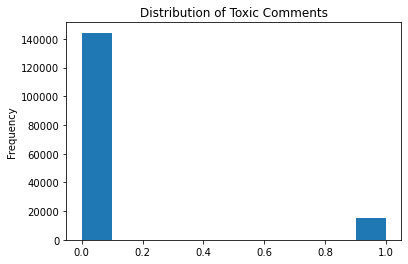

In [23]:
# Plot frequency of toxic comments
train_df1['toxic'].plot(kind='hist', title='Distribution of Toxic Comments');

In [24]:
train_df1['toxic'].value_counts()

0    144277
1     15294
Name: toxic, dtype: int64

### Data Prep — Tokenize and Pad Text Data

In [26]:
max_features = 20000 # number of words we want to keep, top 20.000 words
max_text_length = 400 # max lenght of the comment

In [27]:
x_tokenizer = text.Tokenizer(max_features)

x_tokenizer.fit_on_texts(list(x))

x_tokenized = x_tokenizer.texts_to_sequences(x)

x_train_val = sequence.pad_sequences(x_tokenized, maxlen = max_text_length)

###  Prepare Embedding Matrix with Pre-trained GloVe Embeddings

In [35]:
#!wget http://nlp.stanford.edu/data/glove.6B.zip
#!unzip -q glove.6B.zip

In [37]:
embedding_dim = 100

embedding_index = dict()

f = open('glove.6B.100d.txt')

for line in f:
    values = line.split()
    word = values [0]
    coefs = np.asarray(values [1:], dtype= 'float32')
    embedding_index[word]= coefs

f.close()

print(f'{len(embedding_index)} word vectors are found.')


400000 word vectors are found.


In [39]:
np.zeros((max_features, embedding_dim)).shape


(20000, 100)

In [44]:
list(x_tokenizer.word_index.items())[:10]

[('the', 1),
 ('to', 2),
 ('of', 3),
 ('and', 4),
 ('a', 5),
 ('you', 6),
 ('i', 7),
 ('is', 8),
 ('that', 9),
 ('in', 10)]

In [46]:
embedding_index.get('the')

array([-0.038194, -0.24487 ,  0.72812 , -0.39961 ,  0.083172,  0.043953,
       -0.39141 ,  0.3344  , -0.57545 ,  0.087459,  0.28787 , -0.06731 ,
        0.30906 , -0.26384 , -0.13231 , -0.20757 ,  0.33395 , -0.33848 ,
       -0.31743 , -0.48336 ,  0.1464  , -0.37304 ,  0.34577 ,  0.052041,
        0.44946 , -0.46971 ,  0.02628 , -0.54155 , -0.15518 , -0.14107 ,
       -0.039722,  0.28277 ,  0.14393 ,  0.23464 , -0.31021 ,  0.086173,
        0.20397 ,  0.52624 ,  0.17164 , -0.082378, -0.71787 , -0.41531 ,
        0.20335 , -0.12763 ,  0.41367 ,  0.55187 ,  0.57908 , -0.33477 ,
       -0.36559 , -0.54857 , -0.062892,  0.26584 ,  0.30205 ,  0.99775 ,
       -0.80481 , -3.0243  ,  0.01254 , -0.36942 ,  2.2167  ,  0.72201 ,
       -0.24978 ,  0.92136 ,  0.034514,  0.46745 ,  1.1079  , -0.19358 ,
       -0.074575,  0.23353 , -0.052062, -0.22044 ,  0.057162, -0.15806 ,
       -0.30798 , -0.41625 ,  0.37972 ,  0.15006 , -0.53212 , -0.2055  ,
       -1.2526  ,  0.071624,  0.70565 ,  0.49744 , 

In [47]:
embedding_matrix = np.zeros((max_features, embedding_dim))
for word, index in x_tokenizer.word_index.items():
  if index > max_features -1:
    break
  else:
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
      embedding_matrix[index] = embedding_vector

### Embedding Layer

In [48]:
print('Build model...')
model = Sequential()
# we start off with an efficient embedding layer which maps
# our vocab indices into embedding_dims dimensions
#load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
#(we don't want to update them during training).
model.add(Embedding(max_features,
                    embedding_dim,
                    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                    trainable=False))
model.add(Dropout(0.2))

Build model...


2021-12-29 14:05:13.330232: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Build the Model

In [49]:
filters = 250
kernel_size = 3
hidden_dims = 250

In [50]:
# we add a Convolution1D, which will learn filters
# word group filters of size filter_length:
model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu'))
model.add(MaxPooling1D())
model.add(Conv1D(filters,
                 5,
                 padding='valid',
                 activation='relu'))
# we use max pooling:
model.add(GlobalMaxPooling1D())
# We add a vanilla hidden layer:
model.add(Dense(hidden_dims, activation='relu'))
model.add(Dropout(0.2))

# We project onto 6 output layers, and squash it with a sigmoid:
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         2000000   
                                                                 
 dropout (Dropout)           (None, None, 100)         0         
                                                                 
 conv1d (Conv1D)             (None, None, 250)         75250     
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 250)        0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, None, 250)         312750    
                                                                 
 global_max_pooling1d (Globa  (None, 250)              0         
 lMaxPooling1D)                                         

In [51]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

### Train Model

In [52]:
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y, test_size=0.15, random_state=1)

In [53]:
batch_size = 32
epochs = 3

In [54]:
%%time
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_val, y_val))

Epoch 1/3
4239/4239 [==============================] - 978s 230ms/step - loss: 0.1432 - accuracy: 0.9481 - val_loss: 0.1178 - val_accuracy: 0.9567
Epoch 2/3
4239/4239 [==============================] - 995s 235ms/step - loss: 0.1195 - accuracy: 0.9557 - val_loss: 0.1533 - val_accuracy: 0.9489
Epoch 3/3
4239/4239 [==============================] - 1227s 289ms/step - loss: 0.1098 - accuracy: 0.9594 - val_loss: 0.1130 - val_accuracy: 0.9604
CPU times: user 2h 26min 50s, sys: 9min 57s, total: 2h 36min 48s
Wall time: 53min 20s


### Evaluate Model

In [55]:
model.evaluate(x_val, y_val, batch_size=128)

187/187 [==============================] - 44s 235ms/step - loss: 0.1130 - accuracy: 0.9604


[0.11296900361776352, 0.9603943824768066]

In [60]:
test_df = pd.read_csv('toxic_test.csv')
test_df.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [57]:
x_test = test_df['comment_text'].values

In [58]:
x_test_tokenized = x_tokenizer.texts_to_sequences(x_test)
x_testing = sequence.pad_sequences(x_test_tokenized, maxlen=max_text_length)

In [61]:
y_testing = model.predict(x_testing, verbose = 1, batch_size=32)

4787/4787 [==============================] - 328s 68ms/step


In [62]:
y_testing.shape

(153164, 1)

In [63]:
y_testing[0]

array([0.99182844], dtype=float32)

In [64]:
test_df['Toxic'] = ['not toxic' if x < .5 else 'toxic' for x in y_testing]
test_df[['comment_text', 'Toxic']].head(20)#.sample(20, random_state=1)

,comment_text,Toxic
0,Yo bitch Ja Rule is more succesful then you'll...,toxic
1,== From RfC == \n\n The title is fine as it is...,not toxic
2,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",not toxic
3,":If you have a look back at the source, the in...",not toxic
4,I don't anonymously edit articles at all.,not toxic
5,Thank you for understanding. I think very high...,not toxic
6,Please do not add nonsense to Wikipedia. Such ...,not toxic
7,:Dear god this site is horrible.,not toxic
8,""" \n Only a fool can believe in such numbers. ...",not toxic
9,== Double Redirects == \n\n When fixing double...,not toxic
